# Assignment2

## Question 1

In this part, we randomly created matrix A and B. Learning rate and epochs were defined as well which are 0.001 and 1000 respectively. The backpropagation process is in fitData function.

In [173]:
from __future__ import absolute_import, division, print_function
import numpy as np
import matplotlib.pyplot as plt
import pdb
import tensorflow as tf


lambda1 = 0.001 # learning rate
epochs = 1000
K=2

A = np.random.uniform(0, 1, (K, K))
B = np.random.uniform(0, 1, (K, K))
x = np.random.uniform(0, 1, (K,1))

    
def cal(A, B, x):
    y = np.matmul(A, x)
    u = 1/(1+np.exp(-y))
    v = np.matmul(B, x)
    z = np.matmul(A, np.multiply(u,v))
    w = np.matmul(A, z)
    L = np.square(np.linalg.norm(w, ord=2))
    return L, u, v, w, z

L, u, v, w, z = cal(A, B, x)


def fitData(A, B, x, L, u, v, w, z, K):
    loss = np.zeros(epochs)
    A_old = A
    B_old = B
    for i in range(epochs):
        # to calculate dL/dA
        part1 = 2 * np.matmul(w, np.transpose(z))
        
        aw = np.matmul(np.transpose(A), w)
        part2 = 2*np.matmul(aw, np.transpose(np.multiply(u, v)))
        
        aaw = 2 * np.matmul(np.transpose(A), aw)
        temp = np.multiply(aaw, v)
        d_sig = 1 / (1 + (np.exp(-temp)))
        part3 = np.matmul(np.multiply(d_sig, (1-d_sig)), np.transpose(x))
        
        dL_A = part1 + part2 + part3
        
        # to calculate dL/dB
        dL_B = 2 * np.matmul(np.multiply(aaw, u), np.transpose(x))
        
        A_new = A_old - lambda1*dL_A
        B_new = B_old - lambda1*dL_B
#         pdb.set_trace()
        L_new,_,_,_,_ = cal(A_new, B_new, x)
        loss[i] =L_new
        A_old = A_new
        B_old = B_new
        
    return A, B, loss

A1, B1, loss = fitData(A, B, x, L, u, v, w, z, K)
print("A:{0}".format(A1))
print("B:{0}".format(B1))

A:[[0.35983 0.4185 ]
 [0.56338 0.36215]]
B:[[0.84493 0.80129]
 [0.11387 0.61445]]


Text(0, 0.5, 'loss')

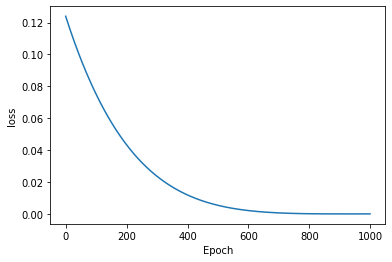

In [174]:
plt.plot(range(epochs), loss)
plt.xlabel('Epoch')
plt.ylabel('loss')


## Question 2

In these two models, we can see the shape of matrix W and matrix (A+B)C are same. From the purpose of softmax function which is to choose the highest probability of classes, the final results of these two models are same which are a group of probability for different classes and the sum of them equal to 1. That means the distribution of the 2 models are same as well.

In this part, we use an example to further prove that this assumption is correct with random matrix W and (A+B)C. Finally, we find the means and variances of them are almost same which proves that they are same models.

In conclusion, these two models are same.

In [34]:
from scipy.special import softmax


N=1000
k=100

#softmax
x1=np.random.normal(size=N)
A1=np.random.normal(size=(k,k))
B1=np.random.normal(size=(k,k))
C1=np.random.normal(size=(k,N))
W1=np.random.normal(size=(k,N))

h1 = softmax(np.matmul(W1,x1), axis=0)

ABC = np.matmul(A1+B1, C1)
ABC_X = np.matmul(ABC, x1)
h2= softmax(ABC_X, axis=0)

print("softmax(Wx):")
print("mean:{0} \nvariance:{1}\n".format(np.mean(h1), np.var(h1)))
print("softmax((A+B)Cx):")
print("mean:{0} \nvariance:{1}".format(np.mean(h2), np.var(h2)))



softmax(Wx):
mean:0.009999999999999959 
variance:0.005703842256732309

softmax((A+B)Cx):
mean:0.01 
variance:0.009899999999999999


## Question 3
In this part, we create 3 different type model based on softmax, MLP and CNN. For each kind of model, we compare the performance of the model with dropout and batchnormalization or not.

First step is to load data

In [35]:
import numpy as np
import struct
import matplotlib.pyplot as plt

train_images_idx3_ubyte_file = './train-images-idx3-ubyte'
train_labels_idx1_ubyte_file = './train-labels-idx1-ubyte'
test_images_idx3_ubyte_file = './t10k-images-idx3-ubyte'
test_labels_idx1_ubyte_file = './t10k-labels-idx1-ubyte'

def decode_idx3_ubyte(idx3_ubyte_file):
    bin_data = open(idx3_ubyte_file, 'rb').read()
    offset = 0
    fmt_header = '>iiii'
    magic_number, num_images, num_rows, num_cols = struct.unpack_from(fmt_header, bin_data, offset)
    print("magic:%d, img:%d, size:%d*%d"% (magic_number, num_images, num_rows, num_cols))
    
    image_size = num_rows * num_cols
    offset += struct.calcsize(fmt_header)
    fmt_image = '>' + str(image_size) + 'B'
    channels = 1
    images = np.empty((num_images, num_rows, num_cols, channels))
    for i in range(num_images):
        if ((i + 1) % 10000) == 0:
            print("loading %d" % (i+1))
        images[i] = np.array(struct.unpack_from(fmt_image, bin_data, offset)).reshape((num_rows, num_cols, channels))
        offset += struct.calcsize(fmt_image)
    return images

def decode_idx1_ubyte(idx1_ubyte_file):
    bin_data = open(idx1_ubyte_file, 'rb').read() 
    offset = 0
    fmt_header = '>ii'
    magic_number, num_images = struct.unpack_from(fmt_header, bin_data, offset)
    print ('magic:%d, image numbers: %d' % (magic_number, num_images))

    offset += struct.calcsize(fmt_header)
    fmt_image = '>B'
    labels = np.empty(num_images)
    for i in range(num_images):
        if (i + 1) % 10000 == 0:
            print ('analysising %d' % (i + 1) )
        labels[i] = struct.unpack_from(fmt_image, bin_data, offset)[0]
        offset += struct.calcsize(fmt_image)
    return labels

def load_train_images(idx_ubyte_file=train_images_idx3_ubyte_file):
    return decode_idx3_ubyte(idx_ubyte_file)

def load_train_labels(idx_ubyte_file=train_labels_idx1_ubyte_file):
    return decode_idx1_ubyte(idx_ubyte_file)

def load_test_images(idx_ubyte_file=test_images_idx3_ubyte_file):
    return decode_idx3_ubyte(idx_ubyte_file)

def load_test_labels(idx_ubyte_file=test_labels_idx1_ubyte_file):
    return decode_idx1_ubyte(idx_ubyte_file)

In [36]:
train_images = load_train_images()#(num_rows*num_cols,num_images)
train_labels = load_train_labels()
test_images = load_test_images()
test_labels = load_test_labels()

magic:2051, img:60000, size:28*28
loading 10000
loading 20000
loading 30000
loading 40000
loading 50000
loading 60000
magic:2049, image numbers: 60000
analysising 10000
analysising 20000
analysising 30000
analysising 40000
analysising 50000
analysising 60000
magic:2051, img:10000, size:28*28
loading 10000
magic:2049, image numbers: 10000
analysising 10000


In [74]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization

### Softmax
The first one(with 6 filters) is the most simple model in Question 3 part so that the performance is not good enough and there is an overfitting problem.

The second one(with 128 filters) which we changed the number of filter in Dense layer is worse than the former one. The curve shows there is a fluctuation which means this model does not have a good generalization ability.
In my opinion, too many filters would result in the lost of features of data. That is the reason why the accuracy of that is lower. 

In [121]:
model_s = models.Sequential()
model_s.add(layers.Flatten())
model_s.add(layers.Dense(6, activation='relu', input_shape=(28, 28, 1)))
model_s.add(layers.Dense(10, activation='softmax'))

model_s.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_s = model_s.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))
test_loss, test_acc = model_s.evaluate(test_images,  test_labels, verbose=2)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 6s 100us/sample - loss: 2.4286 - acc: 0.1120 - val_loss: 2.3011 - val_acc: 0.1134
Epoch 2/10
60000/60000 [==============================] - 5s 76us/sample - loss: 2.3008 - acc: 0.1130 - val_loss: 2.2986 - val_acc: 0.1146
Epoch 3/10
60000/60000 [==============================] - 5s 81us/sample - loss: 2.2858 - acc: 0.1207 - val_loss: 2.2795 - val_acc: 0.1314
Epoch 4/10
60000/60000 [==============================] - 5s 84us/sample - loss: 2.2356 - acc: 0.1437 - val_loss: 2.1924 - val_acc: 0.1600
Epoch 5/10
60000/60000 [==============================] - 5s 81us/sample - loss: 2.1406 - acc: 0.1764 - val_loss: 2.1105 - val_acc: 0.1928
Epoch 6/10
60000/60000 [==============================] - 5s 86us/sample - loss: 2.0767 - acc: 0.1895 - val_loss: 2.0912 - val_acc: 0.1684
Epoch 7/10
60000/60000 [==============================] - 5s 82us/sample - loss: 2.0267 - acc: 0.1969 - val_loss: 2

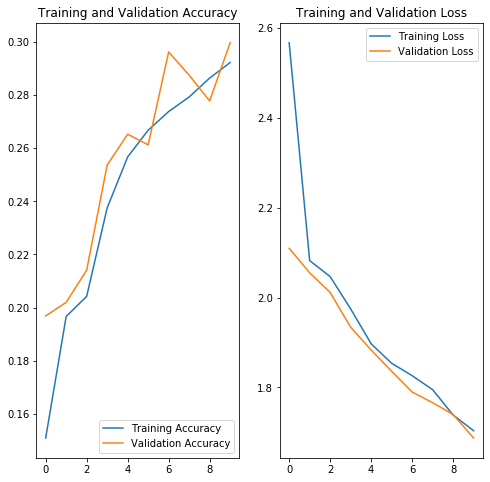

In [41]:
acc = history_s.history['acc']
val_acc = history_s.history['val_acc']

loss = history_s.history['loss']
val_loss = history_s.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [42]:
model_s1 = models.Sequential()
model_s1.add(layers.Flatten())
model_s.add(layers.Dense(128, activation='relu', input_shape=(28, 28, 1)))
model_s1.add(layers.Dense(10, activation='softmax'))

model_s1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_s1 = model_s1.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))
test_loss, test_acc = model_s1.evaluate(test_images,  test_labels, verbose=2)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s 39us/sample - loss: 9.6194 - acc: 0.8388 - val_loss: 5.9266 - val_acc: 0.8757
Epoch 2/10
60000/60000 [==============================] - 2s 39us/sample - loss: 6.1423 - acc: 0.8784 - val_loss: 6.2411 - val_acc: 0.8784
Epoch 3/10
60000/60000 [==============================] - 3s 42us/sample - loss: 5.7210 - acc: 0.8835 - val_loss: 6.9015 - val_acc: 0.8582
Epoch 4/10
60000/60000 [==============================] - 3s 43us/sample - loss: 5.4318 - acc: 0.8853 - val_loss: 4.9768 - val_acc: 0.8994
Epoch 5/10
60000/60000 [==============================] - 2s 38us/sample - loss: 5.4388 - acc: 0.8855 - val_loss: 5.5720 - val_acc: 0.8992
Epoch 6/10
60000/60000 [==============================] - 2s 39us/sample - loss: 5.5127 - acc: 0.8889 - val_loss: 6.5450 - val_acc: 0.8744
Epoch 7/10
60000/60000 [==============================] - 2s 37us/sample - loss: 5.3689 - acc: 0.8883 - val_loss: 6.

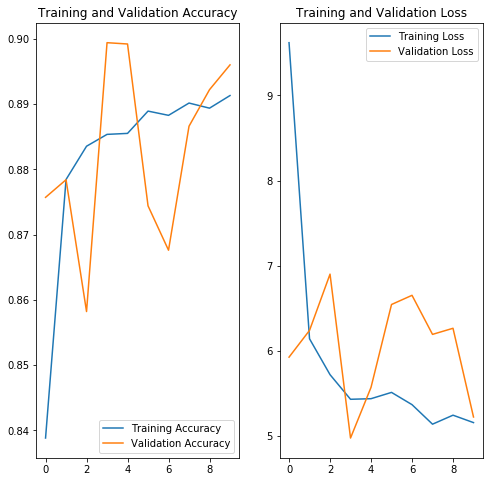

In [43]:
acc = history_s1.history['acc']
val_acc = history_s1.history['val_acc']

loss = history_s1.history['loss']
val_loss = history_s1.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Dropout
We add dropout layer for third model with 6 filters which is same as the first one, which is good for comparing them. It has no good effect on the model. 

However, after I changed the value of dropout from 0.2 to 0.1, the overfitting problem disappeared, although the performance of generalization was not good either.

We then increased the value to 0.5. The final results became worse.

In [175]:
model_s_dr = models.Sequential()
model_s_dr.add(layers.Flatten())
model_s_dr.add(layers.Dense(6, activation='relu', input_shape=(28, 28, 1)))
model_s_dr.add(layers.Dropout(0.2))
model_s_dr.add(layers.Dense(10, activation='softmax'))

model_s_dr.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_s_dr = model_s_dr.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))
test_loss, test_acc = model_s_dr.evaluate(test_images,  test_labels, verbose=2)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 10s 161us/sample - loss: 2.4815 - acc: 0.1295 - val_loss: 2.0938 - val_acc: 0.1900
Epoch 2/10
60000/60000 [==============================] - 7s 120us/sample - loss: 2.1200 - acc: 0.1814 - val_loss: 2.0309 - val_acc: 0.2074
Epoch 3/10
60000/60000 [==============================] - 6s 105us/sample - loss: 2.1020 - acc: 0.1851 - val_loss: 2.0226 - val_acc: 0.2099
Epoch 4/10
60000/60000 [==============================] - 6s 107us/sample - loss: 2.0882 - acc: 0.1873 - val_loss: 2.0070 - val_acc: 0.2113
Epoch 5/10
60000/60000 [==============================] - 6s 107us/sample - loss: 2.0856 - acc: 0.1871 - val_loss: 2.0063 - val_acc: 0.2116
Epoch 6/10
60000/60000 [==============================] - 7s 117us/sample - loss: 2.0788 - acc: 0.1885 - val_loss: 2.0060 - val_acc: 0.2120
Epoch 7/10
60000/60000 [==============================] - 7s 110us/sample - loss: 2.0784 - acc: 0.1901 - val_

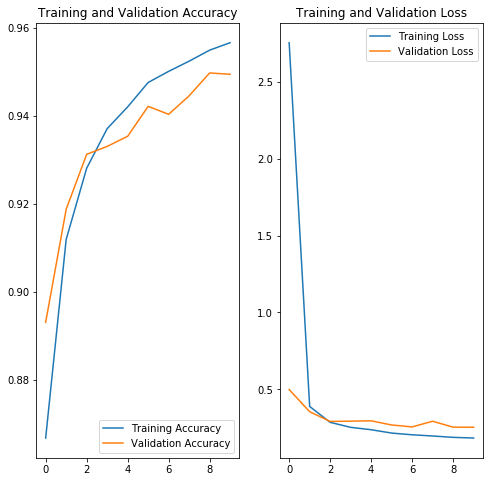

In [45]:
acc = history_s_dr.history['acc']
val_acc = history_s_dr.history['val_acc']

loss = history_s_dr.history['loss']
val_loss = history_s_dr.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [128]:
model_s_dr1 = models.Sequential()
model_s_dr1.add(layers.Flatten())
model_s_dr1.add(layers.Dense(28, activation='relu', input_shape=(28, 28, 1)))
model_s_dr1.add(layers.Dropout(0.1))
model_s_dr1.add(layers.Dense(10, activation='softmax'))

model_s_dr1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_s_dr1 = model_s_dr1.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))
test_loss, test_acc = model_s_dr1.evaluate(test_images,  test_labels, verbose=2)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 7s 120us/sample - loss: 2.2332 - acc: 0.3956 - val_loss: 1.2531 - val_acc: 0.5773
Epoch 2/10
60000/60000 [==============================] - 6s 93us/sample - loss: 1.1381 - acc: 0.6231 - val_loss: 0.8651 - val_acc: 0.7601
Epoch 3/10
60000/60000 [==============================] - 6s 96us/sample - loss: 0.8653 - acc: 0.7271 - val_loss: 0.6357 - val_acc: 0.8229
Epoch 4/10
60000/60000 [==============================] - 5s 86us/sample - loss: 0.7374 - acc: 0.7760 - val_loss: 0.5234 - val_acc: 0.8586
Epoch 5/10
60000/60000 [==============================] - 6s 94us/sample - loss: 0.6658 - acc: 0.8016 - val_loss: 0.4620 - val_acc: 0.8840
Epoch 6/10
60000/60000 [==============================] - 6s 102us/sample - loss: 0.5809 - acc: 0.8256 - val_loss: 0.4274 - val_acc: 0.8876
Epoch 7/10
60000/60000 [==============================] - 6s 98us/sample - loss: 0.5405 - acc: 0.8385 - val_loss: 

In [ ]:
test_loss, test_acc = model_s_dr1.evaluate(test_images,  test_labels, verbose=2)

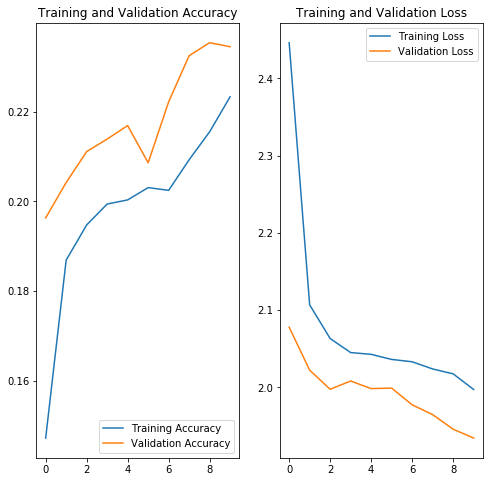

In [48]:
acc = history_s_dr1.history['acc']
val_acc = history_s_dr1.history['val_acc']

loss = history_s_dr1.history['loss']
val_loss = history_s_dr1.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [130]:
model_s_dr2 = models.Sequential()
model_s_dr2.add(layers.Flatten())
model_s_dr2.add(layers.Dense(128, activation='relu', input_shape=(28, 28, 1)))
model_s_dr2.add(layers.Dropout(0.5))
model_s_dr2.add(layers.Dense(10, activation='softmax'))

model_s_dr2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_s_dr3 = model_s_dr2.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))
test_loss, test_acc = model_s_dr2.evaluate(test_images,  test_labels, verbose=2)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 7s 111us/sample - loss: 3.4180 - acc: 0.5274 - val_loss: 0.8632 - val_acc: 0.7835
Epoch 2/10
60000/60000 [==============================] - 6s 93us/sample - loss: 1.1384 - acc: 0.6655 - val_loss: 0.6017 - val_acc: 0.8707
Epoch 3/10
60000/60000 [==============================] - 6s 94us/sample - loss: 0.9528 - acc: 0.7240 - val_loss: 0.5143 - val_acc: 0.8888
Epoch 4/10
60000/60000 [==============================] - 6s 103us/sample - loss: 0.8560 - acc: 0.7561 - val_loss: 0.5247 - val_acc: 0.8965
Epoch 5/10
60000/60000 [==============================] - 6s 105us/sample - loss: 0.8193 - acc: 0.7749 - val_loss: 0.4387 - val_acc: 0.9011
Epoch 6/10
60000/60000 [==============================] - 6s 94us/sample - loss: 0.7582 - acc: 0.7909 - val_loss: 0.4423 - val_acc: 0.9080
Epoch 7/10
60000/60000 [==============================] - 6s 98us/sample - loss: 0.7455 - acc: 0.7948 - val_loss:

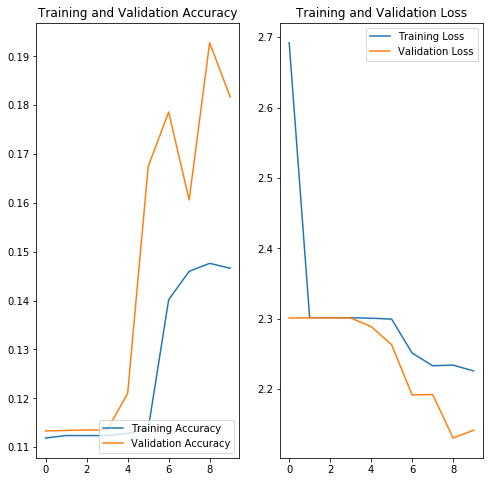

In [52]:
acc = history_s_dr3.history['acc']
val_acc = history_s_dr3.history['val_acc']

loss = history_s_dr3.history['loss']
val_loss = history_s_dr3.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Batch Normalization
We use a worse model which has 128 filters in dense layer for testing. Actually, if we just add BN in our model, it cannot get a improvement instead get a worse result. However, if we conbine BN and dropout, the performence of our model will be better.

In [122]:
model_s_bn = models.Sequential()
model_s_bn.add(layers.BatchNormalization(input_shape=(28, 28, 1)))
model_s_bn.add(layers.Flatten())
model_s_bn.add(layers.Dense(128, activation='relu'))
model_s.add(layers.BatchNormalization())
model_s_bn.add(layers.Dense(10, activation='softmax'))

model_s_bn.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_s_bn = model_s_bn.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))
test_loss, test_acc = model_s_bn.evaluate(test_images,  test_labels, verbose=2)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 7s 114us/sample - loss: 0.2141 - acc: 0.9344 - val_loss: 0.1195 - val_acc: 0.9624
Epoch 2/10
60000/60000 [==============================] - 5s 91us/sample - loss: 0.0958 - acc: 0.9710 - val_loss: 0.1048 - val_acc: 0.9695
Epoch 3/10
60000/60000 [==============================] - 6s 103us/sample - loss: 0.0633 - acc: 0.9797 - val_loss: 0.0916 - val_acc: 0.9714
Epoch 4/10
60000/60000 [==============================] - 5s 90us/sample - loss: 0.0507 - acc: 0.9835 - val_loss: 0.0969 - val_acc: 0.9706
Epoch 5/10
60000/60000 [==============================] - 5s 90us/sample - loss: 0.0412 - acc: 0.9866 - val_loss: 0.0892 - val_acc: 0.9747
Epoch 6/10
60000/60000 [==============================] - 6s 106us/sample - loss: 0.0320 - acc: 0.9891 - val_loss: 0.0842 - val_acc: 0.9770
Epoch 7/10
60000/60000 [==============================] - 6s 92us/sample - loss: 0.0281 - acc: 0.9912 - val_loss:

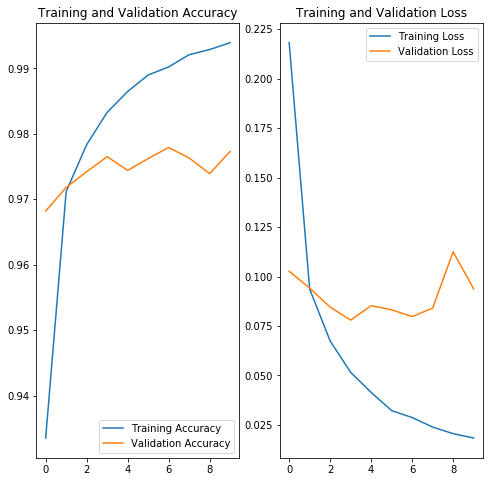

In [56]:
acc = history_s_bn.history['acc']
val_acc = history_s_bn.history['val_acc']

loss = history_s_bn.history['loss']
val_loss = history_s_bn.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [57]:
model_s_bn1 = models.Sequential()
model_s_bn1.add(layers.BatchNormalization(input_shape=(28, 28, 1)))
model_s_bn1.add(layers.Flatten())
model_s_bn1.add(layers.Dense(128, activation='relu'))
model_s_bn1.add(layers.Dropout(0.2))
model_s_bn1.add(layers.BatchNormalization())
model_s_bn1.add(layers.Dense(10, activation='softmax'))

model_s_bn1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_s_bn1 = model_s_bn1.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))
test_loss, test_acc = model_s_bn1.evaluate(test_images,  test_labels, verbose=2)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 5s 81us/sample - loss: 0.2967 - acc: 0.9108 - val_loss: 0.1380 - val_acc: 0.9603
Epoch 2/10
60000/60000 [==============================] - 5s 77us/sample - loss: 0.1688 - acc: 0.9490 - val_loss: 0.1072 - val_acc: 0.9672
Epoch 3/10
60000/60000 [==============================] - 4s 72us/sample - loss: 0.1371 - acc: 0.9586 - val_loss: 0.0953 - val_acc: 0.9721
Epoch 4/10
60000/60000 [==============================] - 4s 72us/sample - loss: 0.1193 - acc: 0.9634 - val_loss: 0.0902 - val_acc: 0.9710
Epoch 5/10
60000/60000 [==============================] - 4s 72us/sample - loss: 0.1116 - acc: 0.9656 - val_loss: 0.0831 - val_acc: 0.9762
Epoch 6/10
60000/60000 [==============================] - 4s 72us/sample - loss: 0.1047 - acc: 0.9680 - val_loss: 0.0778 - val_acc: 0.9768
Epoch 7/10
60000/60000 [==============================] - 4s 72us/sample - loss: 0.0944 - acc: 0.9703 - val_loss: 0.

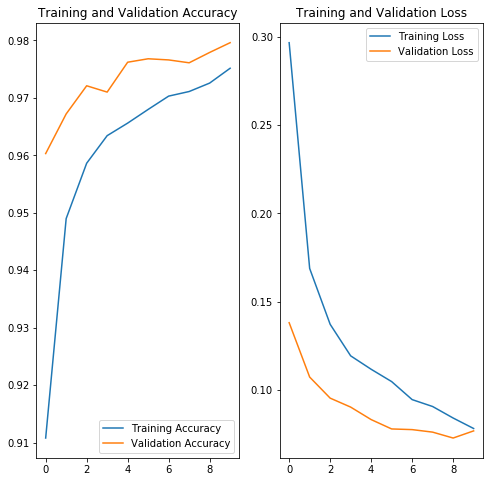

In [58]:
acc = history_s_bn1.history['acc']
val_acc = history_s_bn1.history['val_acc']

loss = history_s_bn1.history['loss']
val_loss = history_s_bn1.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### MLP
MLP is based on softmax. It can get better results than softmax one if the both model have same number of filter.
If the number of dense layer is proper, the more layers,the better model. If the number is too big, there will be overfitting problem.

In [60]:
model_mlp = Sequential()
model_mlp.add(Flatten())
model_mlp.add(Dense(6, activation='relu', input_shape=(28, 28, 1)))
# model.add(Dropout(0.2))
model_mlp.add(Dense(6, activation='relu'))
# model.add(Dropout(0.2))
model_mlp.add(Dense(10, activation='softmax'))

model_mlp.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history_mlp = model_mlp.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))
test_loss, test_acc = model_mlp.evaluate(test_images,  test_labels, verbose=2)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 3s 56us/sample - loss: 2.3372 - acc: 0.1498 - val_loss: 2.0542 - val_acc: 0.2032
Epoch 2/10
60000/60000 [==============================] - 3s 52us/sample - loss: 2.0410 - acc: 0.2027 - val_loss: 2.0075 - val_acc: 0.2078
Epoch 3/10
60000/60000 [==============================] - 3s 52us/sample - loss: 2.0058 - acc: 0.2094 - val_loss: 1.9841 - val_acc: 0.2119
Epoch 4/10
60000/60000 [==============================] - 3s 54us/sample - loss: 1.9644 - acc: 0.2295 - val_loss: 1.8931 - val_acc: 0.2631
Epoch 5/10
60000/60000 [==============================] - 3s 54us/sample - loss: 1.8275 - acc: 0.2759 - val_loss: 1.7607 - val_acc: 0.2872
Epoch 6/10
60000/60000 [==============================] - 3s 57us/sample - loss: 1.7509 - acc: 0.2809 - val_loss: 1.7265 - val_acc: 0.2816
Epoch 7/10
60000/60000 [==============================] - 3s 53us/sample - loss: 1.7279 - acc: 0.2909 - val_loss: 1.

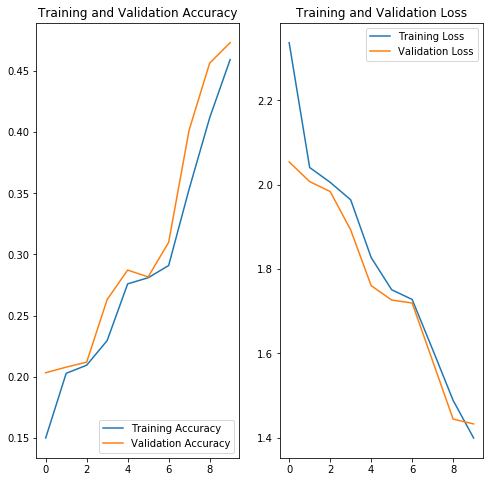

In [61]:
acc = history_mlp.history['acc']
val_acc = history_mlp.history['val_acc']

loss = history_mlp.history['loss']
val_loss = history_mlp.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [62]:
model_mlp1 = Sequential()
model_mlp1.add(Flatten())
model_mlp1.add(Dense(128, activation='relu', input_shape=(28, 28, 1)))
# model.add(Dropout(0.2))
model_mlp1.add(Dense(128, activation='relu'))
# model.add(Dropout(0.2))
model_mlp1.add(Dense(10, activation='softmax'))

model_mlp1.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history_mlp1 = model_mlp1.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))
test_loss, test_acc = model_mlp.evaluate(test_images,  test_labels, verbose=2)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 4s 61us/sample - loss: 1.8250 - acc: 0.8745 - val_loss: 0.4812 - val_acc: 0.9145
Epoch 2/10
60000/60000 [==============================] - 3s 56us/sample - loss: 0.3612 - acc: 0.9265 - val_loss: 0.3205 - val_acc: 0.9244
Epoch 3/10
60000/60000 [==============================] - 4s 61us/sample - loss: 0.2278 - acc: 0.9448 - val_loss: 0.2504 - val_acc: 0.9386
Epoch 4/10
60000/60000 [==============================] - 3s 57us/sample - loss: 0.1731 - acc: 0.9527 - val_loss: 0.2052 - val_acc: 0.9495
Epoch 5/10
60000/60000 [==============================] - 3s 53us/sample - loss: 0.1452 - acc: 0.9597 - val_loss: 0.2012 - val_acc: 0.9490
Epoch 6/10
60000/60000 [==============================] - 3s 52us/sample - loss: 0.1298 - acc: 0.9635 - val_loss: 0.1635 - val_acc: 0.9586
Epoch 7/10
60000/60000 [==============================] - 3s 52us/sample - loss: 0.1173 - acc: 0.9673 - val_loss: 0.

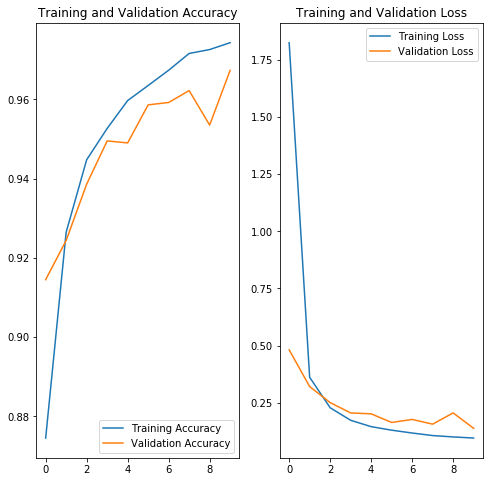

In [63]:
acc = history_mlp1.history['acc']
val_acc = history_mlp1.history['val_acc']

loss = history_mlp1.history['loss']
val_loss = history_mlp1.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [132]:
model_mlp2 = Sequential()
model_mlp2.add(Flatten())
model_mlp2.add(Dense(128, activation='relu', input_shape=(28, 28, 1)))
# model_mlp2.add(Dense(28, activation='relu', input_shape=(28, 28, 1)))

model_mlp2.add(Dense(128, activation='relu'))
model_mlp2.add(Dense(128, activation='relu'))
model_mlp2.add(Dense(128, activation='relu'))
# model_mlp2.add(Dense(56, activation='relu'))

model_mlp2.add(Dense(10, activation='softmax'))

model_mlp2.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history_mlp2 = model_mlp2.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 8s 127us/sample - loss: 0.6346 - acc: 0.8799 - val_loss: 0.2307 - val_acc: 0.9363
Epoch 2/10
60000/60000 [==============================] - 6s 106us/sample - loss: 0.1968 - acc: 0.9439 - val_loss: 0.1754 - val_acc: 0.9507
Epoch 3/10
60000/60000 [==============================] - 7s 111us/sample - loss: 0.1554 - acc: 0.9551 - val_loss: 0.1584 - val_acc: 0.9537
Epoch 4/10
60000/60000 [==============================] - 7s 110us/sample - loss: 0.1333 - acc: 0.9619 - val_loss: 0.1182 - val_acc: 0.9663
Epoch 5/10
60000/60000 [==============================] - 6s 107us/sample - loss: 0.1104 - acc: 0.9686 - val_loss: 0.1349 - val_acc: 0.9637
Epoch 6/10
60000/60000 [==============================] - 6s 108us/sample - loss: 0.0976 - acc: 0.9731 - val_loss: 0.1284 - val_acc: 0.9672
Epoch 7/10
60000/60000 [==============================] - 7s 111us/sample - loss: 0.0910 - acc: 0.9747 - val_l

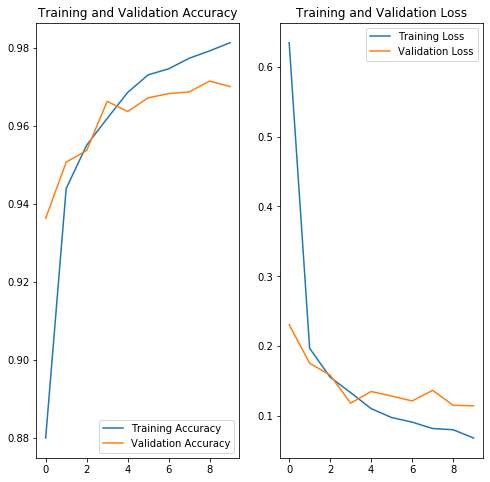

In [133]:
acc = history_mlp2.history['acc']
val_acc = history_mlp2.history['val_acc']

loss = history_mlp2.history['loss']
val_loss = history_mlp2.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### dropout
drop out process has good effects on preventing overfitting.

In [135]:
model_mlp_dp = Sequential()
model_mlp_dp.add(Flatten())
model_mlp_dp.add(Dense(128, activation='relu', input_shape=(28, 28, 1)))
model_mlp_dp.add(Dropout(0.2))
model_mlp_dp.add(Dense(128, activation='relu'))
model_mlp_dp.add(Dropout(0.2))
model_mlp_dp.add(Dense(128, activation='relu'))
model_mlp_dp.add(Dropout(0.2))
model_mlp_dp.add(Dense(128, activation='relu'))
# model_mlp_dp.add(Dense(56, activation='relu'))
model_mlp_dp.add(Dropout(0.2))

model_mlp_dp.add(Dense(10, activation='softmax'))

model_mlp_dp.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history_mlp_dp = model_mlp_dp.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 9s 152us/sample - loss: 1.4795 - acc: 0.6982 - val_loss: 0.3866 - val_acc: 0.8928
Epoch 2/10
60000/60000 [==============================] - 7s 120us/sample - loss: 0.5094 - acc: 0.8613 - val_loss: 0.2794 - val_acc: 0.9229
Epoch 3/10
60000/60000 [==============================] - 7s 119us/sample - loss: 0.4059 - acc: 0.8937 - val_loss: 0.2395 - val_acc: 0.9394
Epoch 4/10
60000/60000 [==============================] - 7s 119us/sample - loss: 0.3564 - acc: 0.9072 - val_loss: 0.2181 - val_acc: 0.9414
Epoch 5/10
60000/60000 [==============================] - 7s 120us/sample - loss: 0.3283 - acc: 0.9166 - val_loss: 0.2109 - val_acc: 0.9468
Epoch 6/10
60000/60000 [==============================] - 7s 120us/sample - loss: 0.3056 - acc: 0.9223 - val_loss: 0.2026 - val_acc: 0.9481
Epoch 7/10
60000/60000 [==============================] - 7s 122us/sample - loss: 0.2840 - acc: 0.9282 - val_l

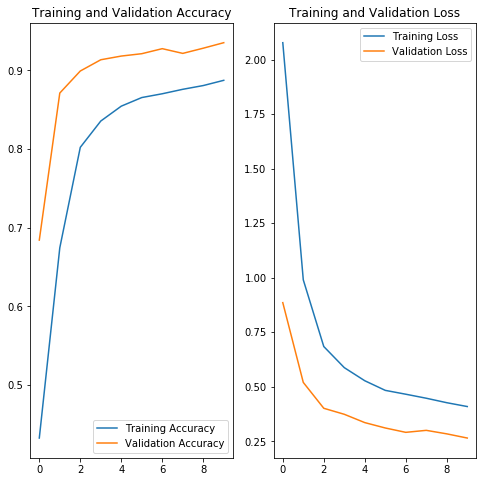

In [72]:
acc = history_mlp_dp.history['acc']
val_acc = history_mlp_dp.history['val_acc']

loss = history_mlp_dp.history['loss']
val_loss = history_mlp_dp.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Bath Normalization




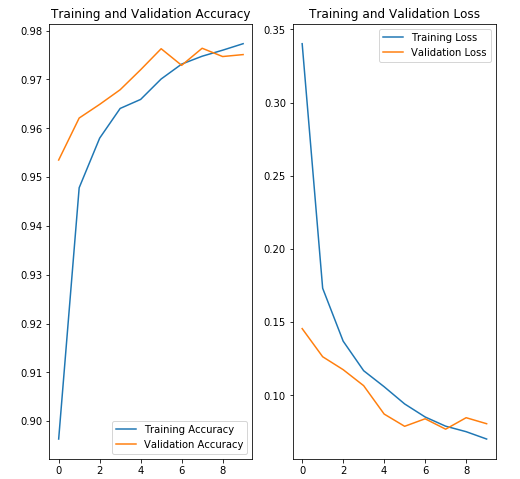

In [137]:
model_mlp_bn = Sequential()
model_mlp_bn.add(BatchNormalization(input_shape=(28, 28, 1)))
model_mlp_bn.add(Flatten())
model_mlp_bn.add(Dense(128, activation='relu'))
# model_mlp_bn.add(Dropout(0.2))
model_mlp_bn.add(BatchNormalization())
model_mlp_bn.add(Dense(128, activation='relu'))
# model_mlp_bn.add(Dropout(0.2))
model_mlp_bn.add(BatchNormalization())
model_mlp_bn.add(Dense(128, activation='relu'))
# model_mlp_bn.add(Dropout(0.2))
model_mlp_bn.add(BatchNormalization())
model_mlp_bn.add(Dense(128, activation='relu'))
# model_mlp_bn.add(Dropout(0.2))
model_mlp_bn.add(BatchNormalization())

model_mlp_bn.add(Dense(10, activation='softmax'))

# model_mlp.summary()

model_mlp_bn.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history_mlp_bn = model_mlp_bn.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 14s 233us/sample - loss: 0.2744 - acc: 0.9153 - val_loss: 0.1264 - val_acc: 0.9593
Epoch 2/10
60000/60000 [==============================] - 12s 195us/sample - loss: 0.1405 - acc: 0.9561 - val_loss: 0.1040 - val_acc: 0.9685
Epoch 3/10
60000/60000 [==============================] - 11s 190us/sample - loss: 0.1127 - acc: 0.9651 - val_loss: 0.0923 - val_acc: 0.9729
Epoch 4/10
60000/60000 [==============================] - 11s 190us/sample - loss: 0.0968 - acc: 0.9697 - val_loss: 0.0831 - val_acc: 0.9745
Epoch 5/10
60000/60000 [==============================] - 11s 191us/sample - loss: 0.0842 - acc: 0.9735 - val_loss: 0.0832 - val_acc: 0.9751
Epoch 6/10
60000/60000 [==============================] - 12s 195us/sample - loss: 0.0702 - acc: 0.9778 - val_loss: 0.0733 - val_acc: 0.9768
Epoch 7/10
60000/60000 [==============================] - 12s 195us/sample - loss: 0.0652 - acc: 0.9789 

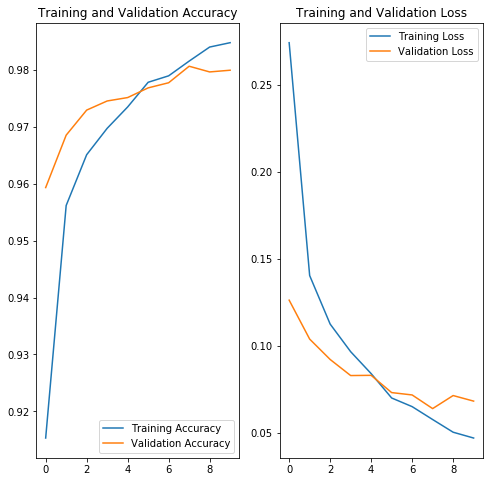

In [138]:
acc = history_mlp_bn.history['acc']
val_acc = history_mlp_bn.history['val_acc']

loss = history_mlp_bn.history['loss']
val_loss = history_mlp_bn.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## CNN
At first, we just use 512 filters in convolutional layers, while the results were terrible. The model cannot fit data and converge. We realized too many filters lead to the missing of features. So we changed the number of filters to be smaller and the new model could fit data perfectly.

In [115]:
model_cnn = models.Sequential()
model_cnn.add(layers.BatchNormalization(input_shape=(28, 28, 1)))
model_cnn.add(layers.Conv2D(6, (2, 2), activation='relu'))
model_cnn.add(layers.MaxPooling2D((2, 2)))
# model_cnn.add(layers.BatchNormalization())
model_cnn.add(layers.Conv2D(12, (2, 2), activation='relu'))
model_cnn.add(layers.MaxPooling2D((2, 2)))
# model_cnn.add(layers.BatchNormalization())
model_cnn.add(layers.Conv2D(12, (2, 2), activation='relu'))
model_cnn.add(layers.MaxPooling2D((2, 2)))
# model_cnn.add(layers.BatchNormalization())

# model.summary()

model_cnn.add(layers.Flatten())
model_cnn.add(layers.Dense(12, activation='relu'))
model_cnn.add(layers.Dense(10, activation='softmax'))
# model.summary()
model_cnn.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_cnn = model_cnn.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

test_loss, test_acc = model_cnn.evaluate(test_images,  test_labels, verbose=2)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 9s 145us/sample - loss: 0.5619 - acc: 0.8105 - val_loss: 0.2288 - val_acc: 0.9316
Epoch 2/10
60000/60000 [==============================] - 7s 116us/sample - loss: 0.2030 - acc: 0.9376 - val_loss: 0.1773 - val_acc: 0.9461
Epoch 3/10
60000/60000 [==============================] - 7s 118us/sample - loss: 0.1593 - acc: 0.9505 - val_loss: 0.1372 - val_acc: 0.9571
Epoch 4/10
60000/60000 [==============================] - 8s 128us/sample - loss: 0.1383 - acc: 0.9572 - val_loss: 0.1244 - val_acc: 0.9608
Epoch 5/10
60000/60000 [==============================] - 7s 123us/sample - loss: 0.1247 - acc: 0.9614 - val_loss: 0.1113 - val_acc: 0.9653
Epoch 6/10
60000/60000 [==============================] - 7s 122us/sample - loss: 0.1145 - acc: 0.9647 - val_loss: 0.1131 - val_acc: 0.9640
Epoch 7/10
60000/60000 [==============================] - 7s 124us/sample - loss: 0.1065 - acc: 0.9671 - val_l

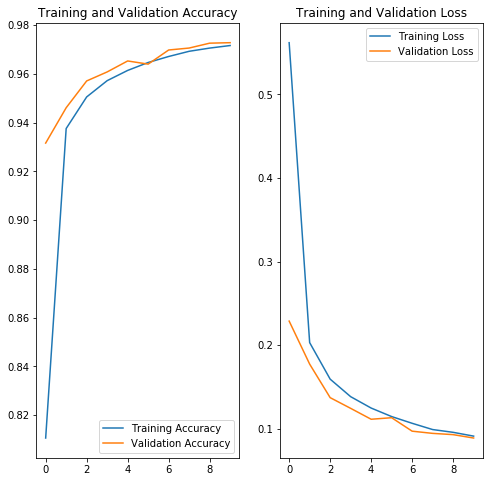

In [116]:
acc = history_cnn.history['acc']
val_acc = history_cnn.history['val_acc']

loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [90]:
model_cnn1 = models.Sequential()
model_cnn1.add(layers.BatchNormalization(input_shape=(28, 28, 1)))
model_cnn1.add(layers.Conv2D(32, (2, 2), activation='relu'))
model_cnn1.add(layers.MaxPooling2D((2, 2)))
# model_cnn.add(layers.BatchNormalization())
model_cnn1.add(layers.Conv2D(64, (2, 2), activation='relu'))
model_cnn1.add(layers.MaxPooling2D((2, 2)))
# model_cnn.add(layers.BatchNormalization())
model_cnn1.add(layers.Conv2D(64, (2, 2), activation='relu'))
model_cnn1.add(layers.MaxPooling2D((2, 2)))
# model_cnn.add(layers.BatchNormalization())

# model.summary()

model_cnn1.add(layers.Flatten())
model_cnn1.add(layers.Dense(64, activation='relu'))
model_cnn1.add(layers.Dense(10, activation='softmax'))
# model.summary()
model_cnn1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_cnn1 = model_cnn1.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

test_loss, test_acc = model_cnn1.evaluate(test_images,  test_labels, verbose=2)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 7s 125us/sample - loss: 0.1843 - acc: 0.9439 - val_loss: 0.0761 - val_acc: 0.9756
Epoch 2/10
60000/60000 [==============================] - 7s 123us/sample - loss: 0.0644 - acc: 0.9796 - val_loss: 0.0684 - val_acc: 0.9797
Epoch 3/10
60000/60000 [==============================] - 7s 122us/sample - loss: 0.0482 - acc: 0.9850 - val_loss: 0.0519 - val_acc: 0.9835
Epoch 4/10
60000/60000 [==============================] - 7s 123us/sample - loss: 0.0379 - acc: 0.9875 - val_loss: 0.0407 - val_acc: 0.9885
Epoch 5/10
60000/60000 [==============================] - 7s 119us/sample - loss: 0.0304 - acc: 0.9905 - val_loss: 0.0478 - val_acc: 0.9848
Epoch 6/10
60000/60000 [==============================] - 7s 115us/sample - loss: 0.0262 - acc: 0.9912 - val_loss: 0.0375 - val_acc: 0.9890
Epoch 7/10
60000/60000 [==============================] - 7s 112us/sample - loss: 0.0222 - acc: 0.9924 - val_l

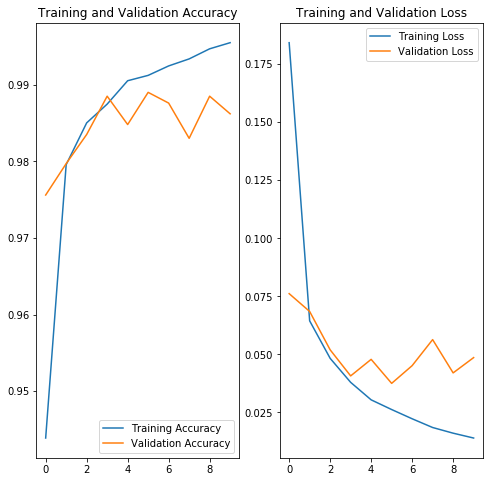

In [91]:
acc = history_cnn1.history['acc']
val_acc = history_cnn1.history['val_acc']

loss = history_cnn1.history['loss']
val_loss = history_cnn1.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [92]:
model_cnn2 = models.Sequential()
model_cnn2.add(layers.BatchNormalization(input_shape=(28, 28, 1)))
model_cnn2.add(layers.Conv2D(6, (3, 3), activation='relu'))
model_cnn2.add(layers.MaxPooling2D((2, 2)))
# model_cnn.add(layers.BatchNormalization())
model_cnn2.add(layers.Conv2D(12, (3, 3), activation='relu'))
model_cnn2.add(layers.MaxPooling2D((2, 2)))
# model_cnn.add(layers.BatchNormalization())
model_cnn2.add(layers.Conv2D(12, (3, 3), activation='relu'))
model_cnn2.add(layers.MaxPooling2D((2, 2)))
# model_cnn.add(layers.BatchNormalization())

# model.summary()

model_cnn2.add(layers.Flatten())
model_cnn2.add(layers.Dense(12, activation='relu'))
model_cnn2.add(layers.Dense(10, activation='softmax'))
# model.summary()
model_cnn2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_cnn2 = model_cnn2.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

test_loss, test_acc = model_cnn2.evaluate(test_images,  test_labels, verbose=2)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 7s 119us/sample - loss: 0.5103 - acc: 0.8356 - val_loss: 0.2254 - val_acc: 0.9283
Epoch 2/10
60000/60000 [==============================] - 6s 101us/sample - loss: 0.2020 - acc: 0.9385 - val_loss: 0.1576 - val_acc: 0.9505
Epoch 3/10
60000/60000 [==============================] - 6s 100us/sample - loss: 0.1544 - acc: 0.9527 - val_loss: 0.1166 - val_acc: 0.9636
Epoch 4/10
60000/60000 [==============================] - 6s 105us/sample - loss: 0.1298 - acc: 0.9605 - val_loss: 0.1094 - val_acc: 0.9661
Epoch 5/10
60000/60000 [==============================] - 6s 107us/sample - loss: 0.1142 - acc: 0.9642 - val_loss: 0.0984 - val_acc: 0.9717
Epoch 6/10
60000/60000 [==============================] - 7s 112us/sample - loss: 0.1033 - acc: 0.9683 - val_loss: 0.0999 - val_acc: 0.9691
Epoch 7/10
60000/60000 [==============================] - 7s 108us/sample - loss: 0.0953 - acc: 0.9712 - val_l

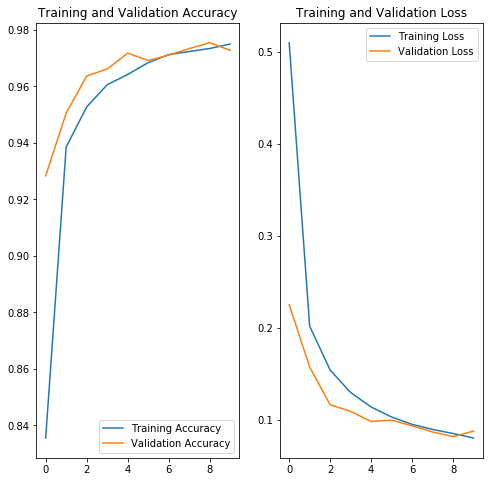

In [93]:
acc = history_cnn2.history['acc']
val_acc = history_cnn2.history['val_acc']

loss = history_cnn2.history['loss']
val_loss = history_cnn2.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Dropout

Solving the overfitting efficiently. 
In addition, for different value of dropout, it will lead to different results. Usually, we choose 0.1 as the value of processing the first output layer.

In [94]:
model_cnn_dr = models.Sequential()
model_cnn_dr.add(layers.BatchNormalization(input_shape=(28, 28, 1)))
model_cnn_dr.add(layers.Conv2D(32, (2, 2), activation='relu'))
model_cnn_dr.add(layers.Dropout(0.2))
model_cnn_dr.add(layers.MaxPooling2D((2, 2)))
# model_cnn.add(layers.BatchNormalization())
model_cnn_dr.add(layers.Conv2D(64, (2, 2), activation='relu'))
model_cnn_dr.add(layers.Dropout(0.2))
model_cnn_dr.add(layers.MaxPooling2D((2, 2)))
# model_cnn.add(layers.BatchNormalization())
model_cnn_dr.add(layers.Conv2D(64, (2, 2), activation='relu'))
model_cnn_dr.add(layers.Dropout(0.2))
model_cnn_dr.add(layers.MaxPooling2D((2, 2)))
# model_cnn.add(layers.BatchNormalization())

# model.summary()

model_cnn_dr.add(layers.Flatten())
model_cnn_dr.add(layers.Dense(64, activation='relu'))
model_cnn_dr.add(layers.Dense(10, activation='softmax'))
# model.summary()
model_cnn_dr.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_cnn_dr = model_cnn_dr.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

test_loss, test_acc = model_cnn_dr.evaluate(test_images,  test_labels, verbose=2)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 9s 155us/sample - loss: 0.2337 - acc: 0.9262 - val_loss: 0.1129 - val_acc: 0.9755
Epoch 2/10
60000/60000 [==============================] - 9s 143us/sample - loss: 0.0901 - acc: 0.9720 - val_loss: 0.0838 - val_acc: 0.9771
Epoch 3/10
60000/60000 [==============================] - 9s 146us/sample - loss: 0.0700 - acc: 0.9779 - val_loss: 0.0558 - val_acc: 0.9844
Epoch 4/10
60000/60000 [==============================] - 9s 147us/sample - loss: 0.0614 - acc: 0.9807 - val_loss: 0.0536 - val_acc: 0.9868
Epoch 5/10
60000/60000 [==============================] - 9s 144us/sample - loss: 0.0541 - acc: 0.9826 - val_loss: 0.0465 - val_acc: 0.9866
Epoch 6/10
60000/60000 [==============================] - 8s 141us/sample - loss: 0.0482 - acc: 0.9845 - val_loss: 0.0431 - val_acc: 0.9875
Epoch 7/10
60000/60000 [==============================] - 9s 149us/sample - loss: 0.0433 - acc: 0.9860 - val_l

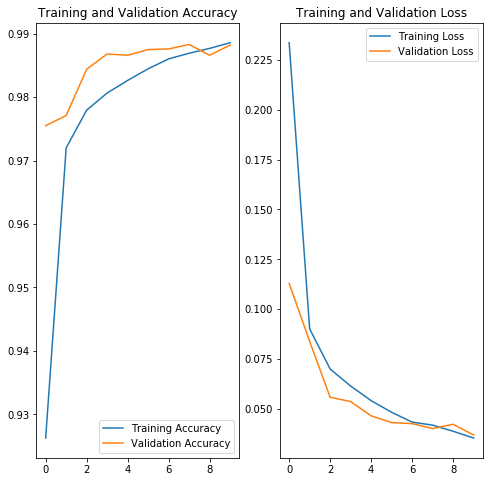

In [95]:
acc = history_cnn_dr.history['acc']
val_acc = history_cnn_dr.history['val_acc']

loss = history_cnn_dr.history['loss']
val_loss = history_cnn_dr.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [96]:
model_cnn_dr1 = models.Sequential()
model_cnn_dr1.add(layers.BatchNormalization(input_shape=(28, 28, 1)))
model_cnn_dr1.add(layers.Conv2D(32, (2, 2), activation='relu'))
model_cnn_dr1.add(layers.Dropout(0.1))
model_cnn_dr1.add(layers.MaxPooling2D((2, 2)))
model_cnn_dr1.add(layers.Conv2D(64, (2, 2), activation='relu'))
model_cnn_dr1.add(layers.Dropout(0.5))
model_cnn_dr1.add(layers.MaxPooling2D((2, 2)))
model_cnn_dr1.add(layers.Conv2D(64, (2, 2), activation='relu'))
model_cnn_dr1.add(layers.Dropout(0.5))
model_cnn_dr1.add(layers.MaxPooling2D((2, 2)))

# model.summary()

model_cnn_dr1.add(layers.Flatten())
model_cnn_dr1.add(layers.Dense(64, activation='relu'))
model_cnn_dr1.add(layers.Dense(10, activation='softmax'))
# model.summary()
model_cnn_dr1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_cnn_dr1 = model_cnn_dr1.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

test_loss, test_acc = model_cnn_dr1.evaluate(test_images,  test_labels, verbose=2)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 9s 158us/sample - loss: 0.3428 - acc: 0.8909 - val_loss: 0.1851 - val_acc: 0.9749
Epoch 2/10
60000/60000 [==============================] - 9s 150us/sample - loss: 0.1420 - acc: 0.9547 - val_loss: 0.1258 - val_acc: 0.9821
Epoch 3/10
60000/60000 [==============================] - 8s 141us/sample - loss: 0.1162 - acc: 0.9629 - val_loss: 0.1161 - val_acc: 0.9809
Epoch 4/10
60000/60000 [==============================] - 9s 152us/sample - loss: 0.0995 - acc: 0.9691 - val_loss: 0.1000 - val_acc: 0.9857
Epoch 5/10
60000/60000 [==============================] - 9s 154us/sample - loss: 0.0920 - acc: 0.9703 - val_loss: 0.0882 - val_acc: 0.9863
Epoch 6/10
60000/60000 [==============================] - 9s 154us/sample - loss: 0.0814 - acc: 0.9731 - val_loss: 0.0834 - val_acc: 0.9850
Epoch 7/10
60000/60000 [==============================] - 10s 165us/sample - loss: 0.0787 - acc: 0.9746 - val_

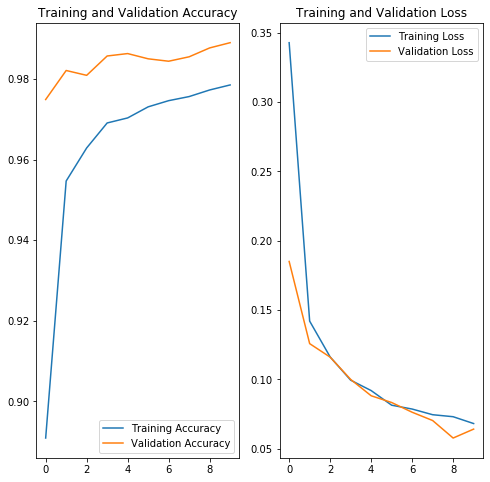

In [97]:
acc = history_cnn_dr1.history['acc']
val_acc = history_cnn_dr1.history['val_acc']

loss = history_cnn_dr1.history['loss']
val_loss = history_cnn_dr1.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Batch Normalization
It takes time for BN layer.

In [98]:
model_bh = models.Sequential()
model_bh.add(layers.BatchNormalization(input_shape=(28, 28, 1)))
model_bh.add(layers.Conv2D(6, (2, 2), activation='relu'))
model_bh.add(layers.MaxPooling2D((2, 2)))
model_bh.add(layers.BatchNormalization())
model_bh.add(layers.Conv2D(12, (2, 2), activation='relu'))
model_bh.add(layers.MaxPooling2D((2, 2)))
model_bh.add(layers.BatchNormalization())
model_bh.add(layers.Conv2D(12, (2, 2), activation='relu'))
model_bh.add(layers.MaxPooling2D((2, 2)))
model_bh.add(layers.BatchNormalization())

# model.summary()

model_bh.add(layers.Flatten())
model_bh.add(layers.Dense(12, activation='relu'))
model_bh.add(layers.Dense(10, activation='softmax'))
# model.summary()
model_bh.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_bh = model_bh.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))
test_loss, test_acc = model_bh.evaluate(test_images,  test_labels, verbose=2)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 9s 149us/sample - loss: 0.5160 - acc: 0.8340 - val_loss: 0.1707 - val_acc: 0.9455
Epoch 2/10
60000/60000 [==============================] - 9s 142us/sample - loss: 0.1490 - acc: 0.9535 - val_loss: 0.1165 - val_acc: 0.9635
Epoch 3/10
60000/60000 [==============================] - 8s 127us/sample - loss: 0.1121 - acc: 0.9651 - val_loss: 0.0988 - val_acc: 0.9687
Epoch 4/10
60000/60000 [==============================] - 8s 126us/sample - loss: 0.0959 - acc: 0.9702 - val_loss: 0.0914 - val_acc: 0.9743
Epoch 5/10
60000/60000 [==============================] - 7s 125us/sample - loss: 0.0832 - acc: 0.9741 - val_loss: 0.0894 - val_acc: 0.9728
Epoch 6/10
60000/60000 [==============================] - 8s 126us/sample - loss: 0.0780 - acc: 0.9755 - val_loss: 0.0792 - val_acc: 0.9766
Epoch 7/10
60000/60000 [==============================] - 8s 127us/sample - loss: 0.0736 - acc: 0.9771 - val_l

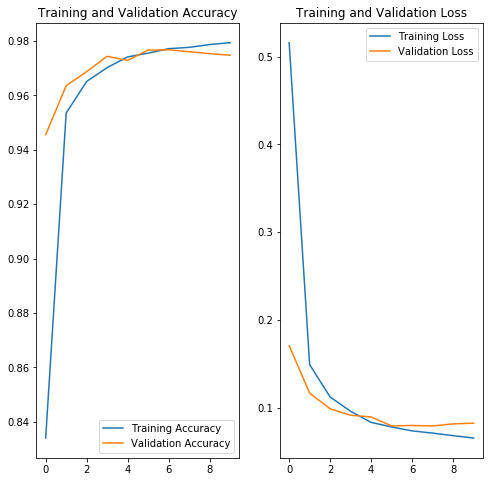

In [99]:
acc = history_bh.history['acc']
val_acc = history_bh.history['val_acc']

loss = history_bh.history['loss']
val_loss = history_bh.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [100]:
model_bh1 = models.Sequential()
model_bh1.add(layers.BatchNormalization(input_shape=(28, 28, 1)))
model_bh1.add(layers.Conv2D(32, (2, 2), activation='relu'))
model_bh1.add(layers.MaxPooling2D((2, 2)))
model_bh1.add(layers.BatchNormalization())
model_bh1.add(layers.Conv2D(64, (2, 2), activation='relu'))
model_bh1.add(layers.MaxPooling2D((2, 2)))
model_bh1.add(layers.BatchNormalization())
model_bh1.add(layers.Conv2D(128, (2, 2), activation='relu'))
model_bh1.add(layers.MaxPooling2D((2, 2)))
model_bh1.add(layers.BatchNormalization())

# model.summary()

model_bh1.add(layers.Flatten())
model_bh1.add(layers.Dense(128, activation='relu'))
model_bh1.add(layers.Dense(10, activation='softmax'))
# model.summary()
model_bh1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_bh1 = model_bh1.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))
test_loss, test_acc = model_bh1.evaluate(test_images,  test_labels, verbose=2)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 10s 169us/sample - loss: 0.1070 - acc: 0.9671 - val_loss: 0.0607 - val_acc: 0.9820
Epoch 2/10
60000/60000 [==============================] - 9s 151us/sample - loss: 0.0456 - acc: 0.9856 - val_loss: 0.0520 - val_acc: 0.9845
Epoch 3/10
60000/60000 [==============================] - 9s 152us/sample - loss: 0.0359 - acc: 0.9886 - val_loss: 0.0544 - val_acc: 0.9844
Epoch 4/10
60000/60000 [==============================] - 8s 137us/sample - loss: 0.0267 - acc: 0.9912 - val_loss: 0.0445 - val_acc: 0.9880
Epoch 5/10
60000/60000 [==============================] - 8s 136us/sample - loss: 0.0214 - acc: 0.9933 - val_loss: 0.0416 - val_acc: 0.9888
Epoch 6/10
60000/60000 [==============================] - 9s 146us/sample - loss: 0.0179 - acc: 0.9943 - val_loss: 0.0411 - val_acc: 0.9894
Epoch 7/10
60000/60000 [==============================] - 9s 154us/sample - loss: 0.0169 - acc: 0.9943 - val_

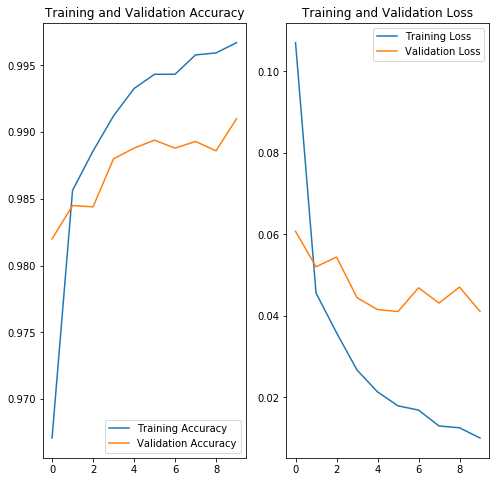

In [101]:
acc = history_bh1.history['acc']
val_acc = history_bh1.history['val_acc']

loss = history_bh1.history['loss']
val_loss = history_bh1.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [110]:
model_bh2 = models.Sequential()
model_bh2.add(layers.BatchNormalization(input_shape=(28, 28, 1)))
model_bh2.add(layers.Conv2D(32, (2, 2), activation='relu'))
model_bh2.add(layers.MaxPooling2D((2, 2)))
model_bh2.add(layers.Dropout(0.1))
model_bh2.add(layers.BatchNormalization())
model_bh2.add(layers.Conv2D(64, (2, 2), activation='relu'))
model_bh2.add(layers.MaxPooling2D((2, 2)))
model_bh2.add(layers.Dropout(0.5))
model_bh2.add(layers.BatchNormalization())
model_bh2.add(layers.Conv2D(128, (2, 2), activation='relu'))
model_bh2.add(layers.Dropout(0.5))
model_bh2.add(layers.MaxPooling2D((2, 2)))
model_bh2.add(layers.BatchNormalization())

# model.summary()

model_bh2.add(layers.Flatten())
model_bh2.add(layers.Dense(128, activation='relu'))
model_bh2.add(layers.Dense(10, activation='softmax'))
# model.summary()
model_bh2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_bh2 = model_bh2.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))
test_loss, test_acc = model_bh2.evaluate(test_images,  test_labels, verbose=2)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 11s 183us/sample - loss: 0.3255 - acc: 0.8935 - val_loss: 0.1117 - val_acc: 0.9651
Epoch 2/10
60000/60000 [==============================] - 10s 161us/sample - loss: 0.1329 - acc: 0.9580 - val_loss: 0.0677 - val_acc: 0.9794
Epoch 3/10
60000/60000 [==============================] - 10s 162us/sample - loss: 0.1091 - acc: 0.9652 - val_loss: 0.0537 - val_acc: 0.9838
Epoch 4/10
60000/60000 [==============================] - 10s 171us/sample - loss: 0.0938 - acc: 0.9705 - val_loss: 0.0535 - val_acc: 0.9852
Epoch 5/10
60000/60000 [==============================] - 11s 176us/sample - loss: 0.0871 - acc: 0.9723 - val_loss: 0.0472 - val_acc: 0.9843
Epoch 6/10
60000/60000 [==============================] - 11s 176us/sample - loss: 0.0800 - acc: 0.9743 - val_loss: 0.0476 - val_acc: 0.9853
Epoch 7/10
60000/60000 [==============================] - 11s 177us/sample - loss: 0.0743 - acc: 0.9760 

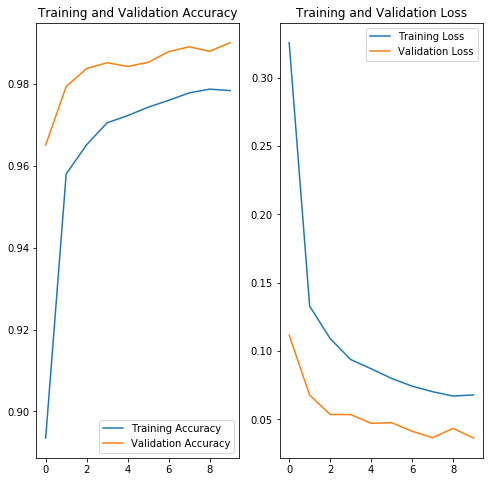

In [111]:
acc = history_bh2.history['acc']
val_acc = history_bh2.history['val_acc']

loss = history_bh2.history['loss']
val_loss = history_bh2.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In next part, if the kerel size is (4 ,4), there will be an error.

In [113]:
model_bh3 = models.Sequential()
model_bh3.add(layers.BatchNormalization(input_shape=(28, 28, 1)))
model_bh3.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_bh3.add(layers.MaxPooling2D((2, 2)))
model_bh3.add(layers.Dropout(0.1))
model_bh3.add(layers.BatchNormalization())
model_bh3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_bh3.add(layers.MaxPooling2D((2, 2)))
model_bh3.add(layers.Dropout(0.5))
model_bh3.add(layers.BatchNormalization())
model_bh3.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_bh3.add(layers.Dropout(0.5))
model_bh3.add(layers.MaxPooling2D((2, 2)))
model_bh3.add(layers.BatchNormalization())

# model.summary()

model_bh3.add(layers.Flatten())
model_bh3.add(layers.Dense(128, activation='relu'))
model_bh3.add(layers.Dense(10, activation='softmax'))
# model.summary()
model_bh3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_bh3 = model_bh3.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))
test_loss, test_acc = model_bh3.evaluate(test_images,  test_labels, verbose=2)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 12s 202us/sample - loss: 0.3354 - acc: 0.8923 - val_loss: 0.0997 - val_acc: 0.9706
Epoch 2/10
60000/60000 [==============================] - 11s 180us/sample - loss: 0.1566 - acc: 0.9513 - val_loss: 0.0809 - val_acc: 0.9769
Epoch 3/10
60000/60000 [==============================] - 10s 174us/sample - loss: 0.1297 - acc: 0.9593 - val_loss: 0.0593 - val_acc: 0.9815
Epoch 4/10
60000/60000 [==============================] - 10s 173us/sample - loss: 0.1156 - acc: 0.9644 - val_loss: 0.0609 - val_acc: 0.9827
Epoch 5/10
60000/60000 [==============================] - 10s 174us/sample - loss: 0.1075 - acc: 0.9657 - val_loss: 0.0509 - val_acc: 0.9859
Epoch 6/10
60000/60000 [==============================] - 11s 177us/sample - loss: 0.0993 - acc: 0.9690 - val_loss: 0.0504 - val_acc: 0.9854
Epoch 7/10
60000/60000 [==============================] - 11s 180us/sample - loss: 0.0970 - acc: 0.9703 

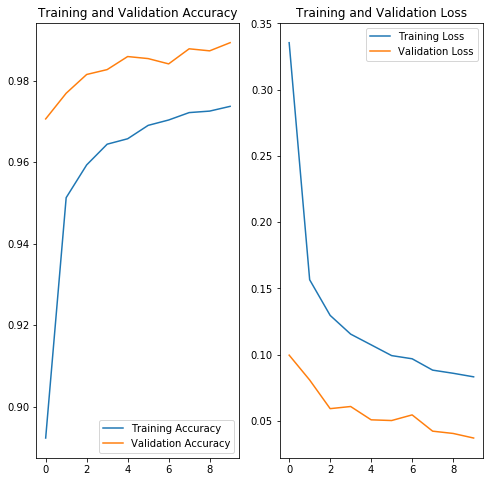

In [114]:
acc = history_bh3.history['acc']
val_acc = history_bh3.history['val_acc']

loss = history_bh3.history['loss']
val_loss = history_bh3.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()